# LSTM Recurrent Neural Network

## Learning Objectives

1. Create map for converting IMDB dataset to readable reviews.
2. Create and build LSTM Recurrent Neural Network.
3. Visualise the Model and train the LSTM.
4. Evaluate model with test data and view results.


## What is this?

This Jupyter Notebook contains Python code for building a LSTM Recurrent Neural Network that gives 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset. 

More information is given on [this blogpost](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

## Introduction 
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!


Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/LSTM_IMDB_Sentiment_Example.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Setting up

When running this for the first time you may get a warning telling you to restart the Runtime. You can ignore this, but feel free to select "Kernel->Restart Kernel" from the overhead menu if you encounter problems.

In [1]:
# keras.datasets.imdb is broken in TensorFlow 1.13 and 1.14 due to numpy 1.16.3
!pip install numpy==1.16.2

# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "IMDB Movie Review" data, constraining our reviews to 
# the 10000 most commonly used words
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]

     |████████████████████████████████| 17.3 MB 6.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tfx-bsl 1.3.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.0 which is incompatible.
tfx-bsl 1.3.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.22.0 which is incompatible.
tfx-bsl 1.3.0 requires pyarrow<3,>=1, but you have pyarrow 5.0.0 which is incompatible.
tfx-bsl 1.3.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,<3,>=1.15.2, but you have tensorflow 2.6.0 whi

2021-09-27 14:33:12.028514: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


17465344/17464789 [==============================] - 0s 0us/step


**Note: Please ignore any incompatibility errors or warnings as it does not impact the notebook's functionality.**

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.x.x


## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also 
contains an index for converting the reviews back into human readable form.

In [2]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
# TODO
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our reviews look like in machine and human readable form?


In [3]:
# Concatenate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> 

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

Some reviews will need to be truncated, while others need to be padded.

In [4]:
# The length of reviews
review_length = 500

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 500)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 500)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## Create and build LSTM Recurrent Neural Network

In [9]:
# We begin by defining an empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()

# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learning during the training process.
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)

# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.
# TODO 
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# We are using a fast version of LSTM which is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine the sentiment of a given review.
# TODO 
model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

# Add a second dropout layer with the same aim as the first.
# TODO 
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# All LSTM units are connected to a single node in the dense layer. A sigmoid 
# activation function determines the output from this node - a value 
# between 0 and 1. Closer to 0 indicates a negative review. Closer to 1 
# indicates a positive review.
model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


## Visualise the Model

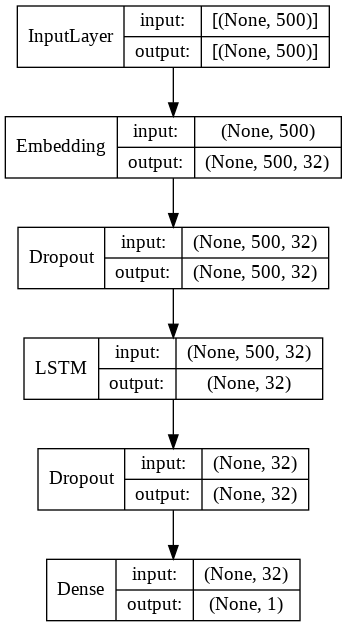

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

In [11]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=256, 

    # An epoch is an iteration over the entire training data.
    epochs=3, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
79/79 [==============================] - 11s 42ms/step - loss: 0.6640 - accuracy: 0.6461 - val_loss: 0.5942 - val_accuracy: 0.7592
Epoch 2/3
79/79 [==============================] - 3s 37ms/step - loss: 0.4047 - accuracy: 0.8402 - val_loss: 0.3422 - val_accuracy: 0.8588
Epoch 3/3
79/79 [==============================] - 3s 37ms/step - loss: 0.2598 - accuracy: 0.9047 - val_loss: 0.2993 - val_accuracy: 0.8816


## Evaluate model with test data and view results

In [12]:
# Get Model Predictions for test data
# TODO 
from sklearn.metrics import classification_report
predicted_classes = np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_test, predicted_classes, target_names=class_names))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.84      0.92      0.88     12500
    Positive       0.91      0.82      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## View some incorrect predictions

Let's have a look at some of the incorrectly classified reviews. For readability we remove the padding.



In [13]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #5: Predicted [Negative] Actual [Positive]
Test Review Text: <START> i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap <UNKNOWN> it deserves the real thing i'm them now this movie will be on dvd

Incorrectly classified Test Review [2]
Test Review #8: Predicted [Positive] Actual [Negative]
Test Review Text: <START> hollywood had a long love affair with bogus <UNKNOWN> nights tales but few of these prod

## Run your own text against the trained model

This is a fun way to test out the limits of the trained model. To avoid getting errors - type in lower case only and do not use punctuation! 

You'll see the raw prediction from the model - basically a value between 0 and 1.



In [14]:
# Write your own review
review = "this was a terrible film with too much sex and violence i walked out halfway through"
#review = "this is the best film i have ever seen it is great and fantastic and i loved it"
#review = "this was an awful film that i will never see again"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 500 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length) 

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

Review: this was a terrible film with too much sex and violence i walked out halfway through
Raw Prediction: 0.24618092
Predicted Class: Negative
